In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns
#try something

In [2]:
df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


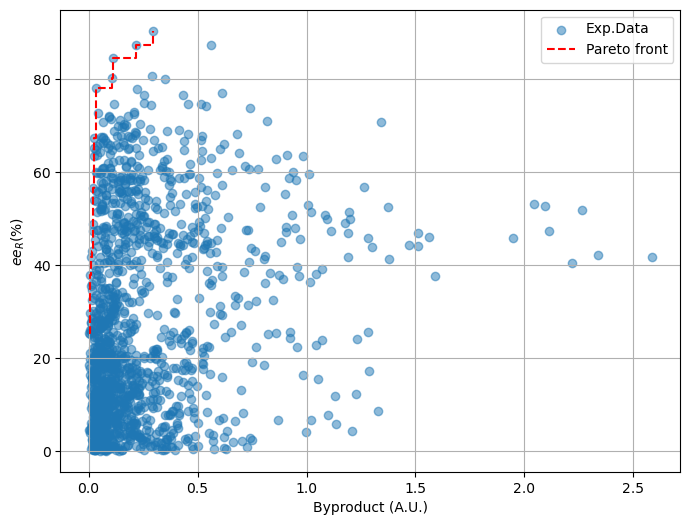

In [3]:
df1 = pd.read_csv('dataset.csv')
df1['abs_ee_R'] = df1['ee_R'].abs()
points = df1[['abs_ee_R', 'yield_undesired_R']].values

def pareto_front_northwest(points):
    pareto = []
    for i, (x, y) in enumerate(points):
        dominated = False
        for j, (x2, y2) in enumerate(points):
            if i != j and x2 >= x and y2 <= y and (x2 > x or y2 < y):
                dominated = True
                break
        if not dominated:
            pareto.append((x, y))
    return np.array(pareto)

pareto_points = pareto_front_northwest(points)

# Sort pareto points by Byproduct (x-axis, pareto_points[:,1])
sorted_indices = np.argsort(pareto_points[:, 1])
pareto_points_sorted = pareto_points[sorted_indices]

plt.figure(figsize=(8, 6))
plt.scatter(points[:, 1], points[:, 0], alpha=0.5, label="Exp.Data")
plt.step(pareto_points_sorted[:, 1], pareto_points_sorted[:, 0], where='post', linestyle='--', color='red', label="Pareto front")
plt.xlabel("Byproduct (A.U.)")
plt.ylabel(r'$\mathit{ee}_{R}(\%)$')
plt.legend()
plt.grid(True)
plt.savefig("Pareto_Front_Sorted.png")
plt.show()


In [4]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


In [5]:
reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from baybe.targets import NumericalTarget
from baybe.objectives import ParetoObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target_1 = NumericalTarget(
    name="ee_R",
    mode="MAX",
)
target_2 = NumericalTarget(
    name="yield_undesired_R",
    mode="MIN",
)


objective = ParetoObjective(targets=[target_1, target_2])
lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R', 'yield_undesired_R']]
lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,catalyst_2,ee_R,yield_undesired_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63,0.095598
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66,0.412281


In [ ]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )


random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)

random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Botorch FPS-Multi": botorch_fps_campaign, "Random": random_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,yield_undesired_R_Measurements,ee_R_IterBest,ee_R_CumBest,yield_undesired_R_IterBest,yield_undesired_R_CumBest
0,Botorch FPS-Multi,0,0,1,[-8.270000457763672],[0.4815824925899505],-8.270000,-8.270000,0.481582,0.481582
1,Botorch FPS-Multi,0,1,2,[70.7699966430664],[1.3405444622039795],70.769997,70.769997,1.340544,0.481582
2,Botorch FPS-Multi,0,2,3,[-8.460000038146973],[0.064078003168106],-8.460000,70.769997,0.064078,0.064078
3,Botorch FPS-Multi,0,3,4,[44.22999954223633],[0.2163449972867965],44.230000,70.769997,0.216345,0.064078
4,Botorch FPS-Multi,0,4,5,[-10.670000076293944],[0.1339949965476989],-10.670000,70.769997,0.133995,0.064078
...,...,...,...,...,...,...,...,...,...,...
295,Random,2,45,46,[-29.209999084472656],[0.6123335361480713],-29.209999,68.269997,0.612334,0.016010
296,Random,2,46,47,[-11.380000114440918],[0.1107750013470649],-11.380000,68.269997,0.110775,0.016010
297,Random,2,47,48,[65.76000213623047],[0.1243200004100799],65.760002,68.269997,0.124320,0.016010
298,Random,2,48,49,[-56.38999938964844],[0.1090250015258789],-56.389999,68.269997,0.109025,0.016010


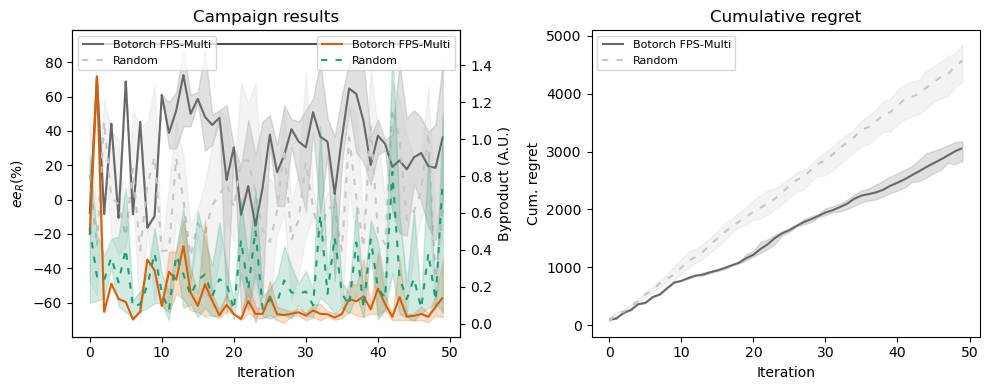

In [ ]:
from utils import plot_results_multi

plot_results_multi(results, lookup, figure_name= 'init_multibo.png', nbr_controls=2)
